# Real Bogus Experiment

We used three subtraction techniques

Zackay's and Bramich's DIA algorithms, plus HOTPANTS source code.
All of them were applied on the same new--ref pair of images and the same source identification algorithm.
Except for an identification algorithm proposed by zackay:
* S detection (with sep)
* S_corr detection with 3.5-$\sigma$ threshold

Each dataset is comparable... 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context(font_scale=16)
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['text.usetex'] = True

In [3]:
from sqlalchemy import create_engine
import pandas as pd

In [4]:
from astropy.stats import sigma_clipped_stats

In [129]:
from ipywidgets import interact, interactive

In [5]:
import os
plot_dir = os.path.abspath('./plots_four/.')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

In [6]:
def custom_histogram(vector, bins=None, cumulative=False, errors=False):
    if bins is None:
        hh = np.histogram(vector)
    else: 
        hh = np.histogram(vector, bins=bins)
    dx = hh[1][1] - hh[1][0]
    x_bins = hh[1][:-1] + dx

    if cumulative is True:
        vals = [sum(hh[0][:i+1]) for i, _ in enumerate(hh[0])]
        if errors:
            err = np.sqrt(hh[0])
            return x_bins, vals, err
        return x_bins, vals

    elif cumulative == -1:
        vals = [sum(hh[0][i:]) for i, _ in enumerate(hh[0])]
        if errors:
            err = np.sqrt(hh[0])
            return x_bins, vals, err
        return x_bins, vals
    
    else:
        if errors:
            err = np.sqrt(hh[0])
            return x_bins, hh[0], err
        
        return x_bins, hh[0]

In [7]:
engine = create_engine('sqlite:///../RBpipeline/newrbogus22-dev.db')

Asking to the database for the undetected objects (False Negatives)

In [8]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [9]:
und_z = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN Undetected U
                             ON S.id==U.simulated_id""", 
                          engine)

In [10]:
und_s = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN SUndetected U
                             ON S.id==U.simulated_id""", 
                          engine)

In [11]:
und_sc = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN SCorrUndetected U
                             ON S.id==U.simulated_id""", 
                          engine)

In [12]:
und_b = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedOIS U
                             ON S.id==U.simulated_id""", 
                          engine)

In [13]:
und_h = pd.read_sql_query("""SELECT S.x, S.y, S.app_mag, S.image_id, U.simulated_id 
                             FROM Simulated S INNER JOIN UndetectedHOT U
                             ON S.id==U.simulated_id""", 
                          engine)

In [14]:
und_b.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

Querying the database to obtain the tables related to the detections.

In [15]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [16]:
dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [17]:
dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [18]:
dt_sps = pd.merge(pd.read_sql_table('SDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM SDetected
                                        LEFT JOIN SReals
                                            ON SDetected.id==SReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [19]:
dt_scr = pd.merge(pd.read_sql_table('SCorrDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SCorrDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM SCorrDetected
                                        LEFT JOIN SCorrReals
                                            ON SCorrDetected.id==SCorrReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SCorrReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [20]:
# dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
# dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)

### Some plots of simulated objects

In [21]:
sim_images = pd.read_sql_table('Images', engine)

In [22]:
len(simulated)

96792

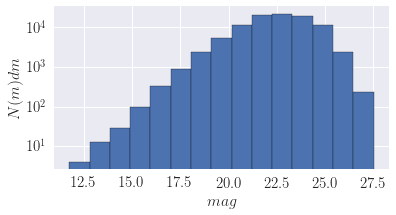

In [23]:
plt.figure(figsize=(6,3))
plt.hist(simulated['app_mag'], cumulative=False, bins=15, log=True)
plt.xlabel(r'$mag$', fontsize=16)
plt.tick_params(labelsize=15)
plt.ylabel(r'$N(m) dm$', fontsize=16)
#plt.ylabel(r'$\int_{-\infty}^{mag}\phi(m\prime)dm\prime$', fontsize=16)
plt.savefig(os.path.join(plot_dir, 'lum_fun_simulated.png'), dpi=400)

In [24]:
object_params = pd.merge(left=sim_images, right=simulated, right_on='image_id', left_on='id', how='right')

In [25]:
sub_tab = object_params[['refstarcount_zp', u'refstarcount_slope', u'refseeing_fwhm', 
                         u'app_mag', u'r_scales', u'gx_mag']]

In [26]:
sub_tab.describe()

,refstarcount_zp,refstarcount_slope,refseeing_fwhm,app_mag,r_scales,gx_mag
count,96792.000000,96792.000000,96792.000000,96792.000000,96792.000000,96792.000000
mean,24117.613026,0.499620,1.101050,22.500130,2.509356,22.499775
std,21637.386025,0.283329,0.223421,1.754223,1.446241,1.321982
min,4000.000000,0.100000,0.800000,11.736346,0.000008,12.221800
25%,8000.000000,0.300000,1.000000,21.425018,1.258247,21.857800
50%,16000.000000,0.500000,1.200000,22.595216,2.514549,22.817100
75%,32000.000000,0.700000,1.400000,23.777486,3.764245,23.331900
max,64000.000000,0.900000,1.400000,27.519948,4.999934,25.648200


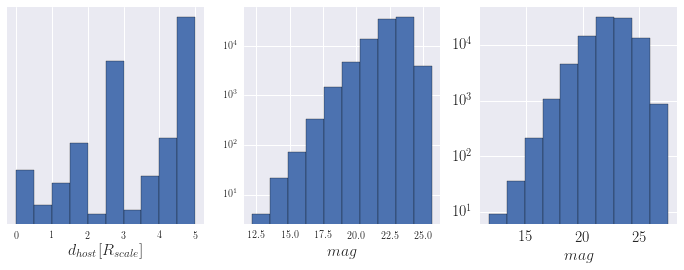

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist(sub_tab['r_scales'], log=True)
plt.xlabel(r'$d_{host}[R_{scale}]$', fontsize=16)
plt.subplot(132)
plt.hist(sub_tab['gx_mag'], log=True)
plt.xlabel(r'$mag$', fontsize=16)
plt.subplot(133)
plt.hist(sub_tab['app_mag'], log=True)
plt.xlabel(r'$mag$', fontsize=16)
plt.tick_params(labelsize=15)
plt.savefig(os.path.join(plot_dir, 'par_dist.png'), dpi=700)

### Analyzing the fraction of type of objects for each dataset

In [134]:
@interact(significance_th=(-1000,4000,100))
def sign_plot(significance_th=-500):
    dataset = dt_scr
    bins = np.arange(-400, 4000, 100)
    data = dataset[dataset.SIGNIFICANCE>significance_th]
    plt.hist(data[data.IS_REAL==0].SIGNIFICANCE, color='red', log=True, bins=bins)
    plt.hist(data[data.IS_REAL==1].SIGNIFICANCE, color='blue', log=True, bins=bins, alpha=0.5)
    plt.show()

In [28]:
ois = [sum(dt_ois.IS_REAL), len(und_b), len(dt_ois.IS_REAL)-sum(dt_ois.IS_REAL)]
zps = [sum(dt_zps.IS_REAL), len(und_z), len(dt_zps.IS_REAL)-sum(dt_zps.IS_REAL)]
hot = [sum(dt_hot.IS_REAL), len(und_h), len(dt_hot.IS_REAL)-sum(dt_hot.IS_REAL)]
sps = [sum(dt_sps.IS_REAL), len(und_s), len(dt_sps.IS_REAL)-sum(dt_sps.IS_REAL)]
scr = [sum(dt_scr.IS_REAL), len(und_sc), len(dt_scr.IS_REAL)-sum(dt_scr.IS_REAL)]
df2 = pd.DataFrame([zps, ois, hot, sps, scr], 
                   columns=['Real', 'False Neg', 'Bogus'])

In [29]:
df2['Hallados'] = df2['Real']/(df2['Real']+df2['False Neg'])
df2['Perdidos'] = df2['False Neg']/(df2['Real']+df2['False Neg'])
df2['Falsos'] = df2['Bogus']/(df2['Real']+df2['False Neg'])

In [30]:
print df2.to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &   Real &  False Neg &   Bogus &  Hallados &  Perdidos &    Falsos \\
\midrule
0 &  44676 &      52116 &   11388 &  0.461567 &  0.538433 &  0.117654 \\
1 &  47647 &      49145 &  112481 &  0.492262 &  0.507738 &  1.162090 \\
2 &  49757 &      47035 &   70662 &  0.514061 &  0.485939 &  0.730040 \\
3 &  35803 &      60989 &   50873 &  0.369896 &  0.630104 &  0.525591 \\
4 &  35923 &      60869 &   65283 &  0.371136 &  0.628864 &  0.674467 \\
\bottomrule
\end{tabular}



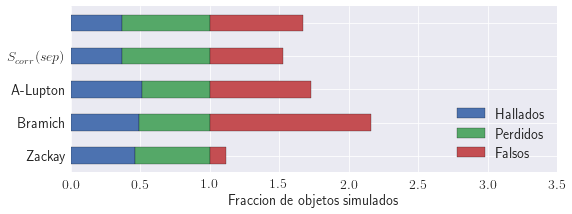

In [31]:
#plt.figure(figsize=(8, 4)
with sns.plotting_context('paper', rc={'figure.figsize': [8, 3]}):

    df2[['Hallados', 'Perdidos', 'Falsos']].plot.barh(stacked=True)
    #plt.title('Fraccion de objetos', fontsize=14)
    plt.xscale('linear')
    plt.xlabel('Fraccion de objetos simulados', fontsize=14)
    plt.xlim(0, 3.5)
    plt.yticks([0,1,2,3,4],# 5], 
               ['Zackay', 'Bramich', 'A-Lupton', '$S_{corr}(sep)$'],#, '$S_{corr}(5\sigma)$'], 
               fontsize=14)

    plt.vlines(df2[1:2]['Real'], -0.4, 2.3, lw=0.3)
    plt.vlines(df2[1:2]['Real']+df2[1:2]['False Neg'], -0.4, 2.3, lw=0.6)

    plt.tight_layout()
    plt.legend(loc='lower right', fontsize=14)
    plt.tick_params(labelsize=14)
    plt.savefig(os.path.join(plot_dir, 'fractions_classes.svg'), format='svg', dpi=720)

In [32]:
def TruePositives(dt, thresh, tot_sim):
    detections = dt[dt.SIGNIFICANCE>thresh]
    return np.sum(detections.IS_REAL)/float(tot_sim)

def FalseNegatives(dt, thresh, tot_sim):
    return 1.-TruePositives(dt, thresh, tot_sim)

def FalsePositives(dt, thresh, tot_sim):
    detections = dt[dt.SIGNIFICANCE>thresh]
    return (len(detections) - np.sum(detections.IS_REAL))/float(tot_sim)

In [33]:
tot_sim = len(simulated)
print TruePositives(dt_scr, 3.5, tot_sim)
print FalseNegatives(dt_scr, 3.5, tot_sim)
print FalsePositives(dt_scr, 3.5, tot_sim)

0.370082238202
0.629917761798
0.647718819737


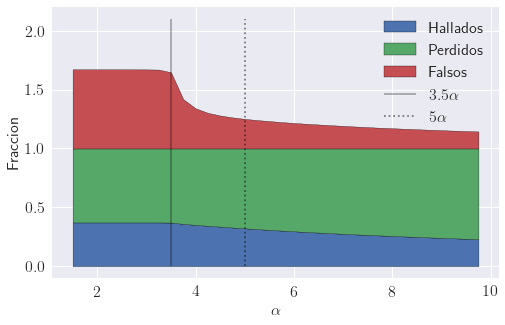

In [34]:
#plt.rcParams['text.usetex'] = True
plt.figure(figsize=(8, 5))
plt.fill_between(x=np.arange(1.5, 10., 0.25), y1=0.,
                 y2=[TruePositives(dt_scr, th, tot_sim) for th in np.arange(1.5, 10., 0.25)],
                 label='Hallados', alpha=1)

plt.fill_between(x=np.arange(1.5, 10., 0.25), 
                 y1=[TruePositives(dt_scr, th, tot_sim) for th in np.arange(1.5, 10., 0.25)], 
                 y2=1, label='Perdidos')

plt.fill_between(x=np.arange(1.5, 10., 0.25), y1=1.,
                 y2=[1.+FalsePositives(dt_scr, th, tot_sim) for th in np.arange(1.5, 10., 0.25)],
                 label='Falsos')
plt.vlines(x=3.5, ymax=2.1, ymin=0., label=r'$3.5\alpha$', alpha=0.3)
plt.vlines(x=5, linestyle=':', ymax=2.1, ymin=0., label=r'$5\alpha$', alpha=0.5)

plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('Fraccion', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig(os.path.join(plot_dir, 'scorr_thresholds.png'), dpi=720)

In [35]:
import gc
gc.collect()

50757

## Magnitude offset

We need to calculate the magnitude offset to understand how to compare perfomances.

In [36]:
cx_sps = pd.read_sql_query(
"""SELECT 
  SDetected.cflux, 
  SDetected.flux, 
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM SDetected
  INNER JOIN SReals
    ON SDetected.id==SReals.detected_id
  INNER JOIN Simulated
    ON Simulated.id==SReals.simulated_id""", engine)

In [37]:
cx_sps['MAG_APER'] = -2.5*np.log10(cx_sps.cflux)

In [38]:
cx_sps.columns

Index([u'cflux', u'flux', u'sim_mag', u'sim_id', u'MAG_APER'], dtype='object')

In [39]:
cx_zps = pd.read_sql_query(
"""SELECT 
  Detected.MAG_ISO, 
  Detected.MAG_AUTO, 
  Detected.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM Detected
  INNER JOIN Reals
    ON Detected.id==Reals.detected_id
  INNER JOIN Simulated
    ON Simulated.id==Reals.simulated_id""", engine)

In [40]:
cx_ois = pd.read_sql_query(
"""SELECT 
  DetectedOIS.MAG_ISO,
  DetectedOIS.MAG_AUTO,
  DetectedOIS.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedOIS
  INNER JOIN RealsOIS
    ON DetectedOIS.id==RealsOIS.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsOIS.simulated_id""", engine)

In [41]:
cx_hot = pd.read_sql_query(
"""SELECT 
  DetectedHOT.MAG_ISO,
  DetectedHOT.MAG_AUTO,
  DetectedHOT.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedHOT
  INNER JOIN RealsHOT
    ON DetectedHOT.id==RealsHOT.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsHOT.simulated_id""", engine)

In [42]:
detections = pd.merge(cx_ois, cx_zps, how='outer', on='sim_id', suffixes=('_ois','_zps'))

In [43]:
detections.columns

Index([u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois', u'sim_mag_ois',
       u'sim_id', u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps',
       u'sim_mag_zps'],
      dtype='object')

In [44]:
detections = pd.merge(cx_hot, detections, how='outer', on='sim_id', suffixes=('_hot', '_'))

In [45]:
detections.columns

Index([u'MAG_ISO', u'MAG_AUTO', u'MAG_APER', u'sim_mag', u'sim_id',
       u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois', u'sim_mag_ois',
       u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps', u'sim_mag_zps'],
      dtype='object')

In [46]:
detections = pd.merge(cx_sps, detections, how='outer', on='sim_id', suffixes=('_sps', '_'))

In [47]:
detections.columns

Index([       u'cflux',         u'flux',  u'sim_mag_sps',       u'sim_id',
       u'MAG_APER_sps',      u'MAG_ISO',     u'MAG_AUTO',    u'MAG_APER_',
           u'sim_mag_',  u'MAG_ISO_ois', u'MAG_AUTO_ois', u'MAG_APER_ois',
        u'sim_mag_ois',  u'MAG_ISO_zps', u'MAG_AUTO_zps', u'MAG_APER_zps',
        u'sim_mag_zps'],
      dtype='object')

In [48]:
detections = detections.dropna()

In [49]:
detections['MAG_OFFSET_zps'] = detections['sim_mag_zps'] - detections['MAG_APER_zps']
detections['MAG_OFFSET_ois'] = detections['sim_mag_ois'] - detections['MAG_APER_ois']
detections['MAG_OFFSET_hot'] = detections['sim_mag_'] - detections['MAG_APER_']
detections['MAG_OFFSET_sps'] = detections['sim_mag_sps'] - detections['MAG_APER_sps']

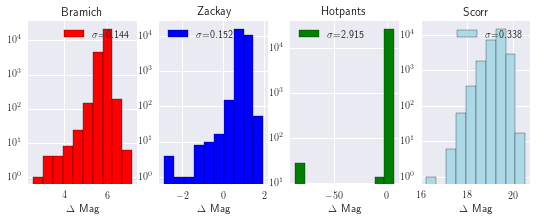

In [50]:
plt.figure(figsize=(9,3))
plt.subplot(141)
plt.hist(detections['MAG_OFFSET_ois'], log=True, color='red',
        label=r'$\sigma$={}'.format(round(np.std(detections['MAG_OFFSET_ois']), 3)))
plt.title('Bramich')
plt.xlabel(r'$\Delta$ Mag')
plt.legend(loc='best')

plt.subplot(142)
plt.hist(detections['MAG_OFFSET_zps'], log=True, color='blue',
        label=r'$\sigma$={}'.format(round(np.std(detections['MAG_OFFSET_zps']), 3)))
plt.xlabel(r'$\Delta$ Mag')
plt.title('Zackay')
plt.legend(loc='best')

plt.subplot(143)
plt.hist(detections['MAG_OFFSET_hot'], log=True, color='green', 
         label=r'$\sigma$={}'.format(round(np.std(detections['MAG_OFFSET_hot']), 3)))
plt.xlabel(r'$\Delta$ Mag')
plt.title('Hotpants')
plt.legend(loc='best')

plt.subplot(144)
plt.hist(detections['MAG_OFFSET_sps'], log=True, color='lightblue', 
         label=r'$\sigma$={}'.format(round(np.std(detections['MAG_OFFSET_sps']), 3)))
plt.xlabel(r'$\Delta$ Mag')
plt.title('Scorr')
plt.legend(loc='best')
plt.show()

plt.savefig(os.path.join(plot_dir, 'mag_offset.png'), format='png', dpi=700)

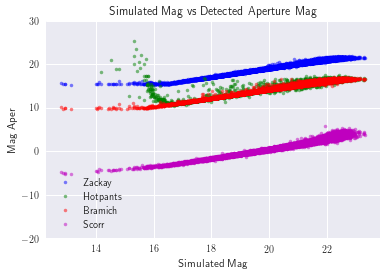

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(detections['sim_mag_zps'], detections['MAG_APER_zps'], 'b.', label='Zackay', alpha=0.5)
plt.plot(detections['sim_mag_'], detections['MAG_APER_'], 'g.', label='Hotpants', alpha=0.5)
plt.plot(detections['sim_mag_ois'], detections['MAG_APER_ois'], 'r.', label='Bramich', alpha=0.5)
plt.plot(detections['sim_mag_sps'], detections['MAG_APER_sps'], 'm.', label='Scorr', alpha=0.5)

plt.ylim(-20, 30)
plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')
plt.savefig(os.path.join(plot_dir, 'aper_vs_simulated_mag.png'), format='png', dpi=700)

In [52]:
mean_offset_zps, median_offset_zps, std_offset_zps = sigma_clipped_stats(detections.MAG_OFFSET_zps)
mean_offset_ois, median_offset_ois, std_offset_ois = sigma_clipped_stats(detections.MAG_OFFSET_ois)
mean_offset_hot, median_offset_hot, std_offset_hot = sigma_clipped_stats(detections.MAG_OFFSET_hot)
mean_offset_sps, median_offset_sps, std_offset_sps = sigma_clipped_stats(detections.MAG_OFFSET_sps)

print 'Mean magniutde difference for Zackay is {}'.format(median_offset_zps)
print 'Mean magniutde difference for Bramich is {}'.format(median_offset_ois)
print 'Mean magniutde difference for Hotpans is {}'.format(median_offset_hot)
print 'Mean magniutde difference for Scorr is {}'.format(median_offset_sps)

Mean magniutde difference for Zackay is 0.952890475192
Mean magniutde difference for Bramich is 5.85970803911
Mean magniutde difference for Hotpans is 5.87511186008
Mean magniutde difference for Scorr is 19.4029230795


In [53]:
dt_ois['mag'] = dt_ois['MAG_APER'] + median_offset_ois
dt_zps['mag'] = dt_zps['MAG_APER'] + median_offset_zps
dt_hot['mag'] = dt_hot['MAG_APER'] + median_offset_hot
dt_sps['mag'] = -2.5*np.log10(dt_sps['cflux']) + median_offset_sps

In [54]:
dt_hot = dt_hot[dt_hot.mag <30]
dt_ois = dt_ois[dt_ois.mag <30]
dt_zps = dt_zps[dt_zps.mag <30]
#dt_sps = dt_sps[dt_sps.mag <30]

In [55]:
def binning(data, bins, return_center_bins=False):
    mean = np.zeros_like(bins[:-1])
    stdv = np.zeros_like(bins[:-1])
    sqrtn= np.zeros_like(mean)
    mean_sim_mag = np.zeros_like(mean)
    for i_bin, low in enumerate(bins[:-1]):
        high = bins[i_bin+1]
        mean_sim_mag[i_bin] = (high+low)/2.
        f1data = data[data['mag']<25]
        fdata = f1data[(f1data['sim_mag'] < high) * (f1data['sim_mag'] >= low)]
        #print len(fdata)
        if len(fdata) is 0:
            sqrtn[i_bin] = 0
            mean[i_bin] = 0#np.median(fdata['mag'])
            stdv[i_bin] = 0#np.std(fdata['mag'])
            continue
        sqrtn[i_bin] = np.sqrt(len(fdata['mag'])-1)
        mean[i_bin] = np.median(fdata['mag'])
        stdv[i_bin] = np.std(fdata['mag'])
    if return_center_bins:
        return bins[:-1]+(high-low)*0.5, mean, stdv, sqrtn
    else:
        return mean, stdv, sqrtn, mean_sim_mag

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


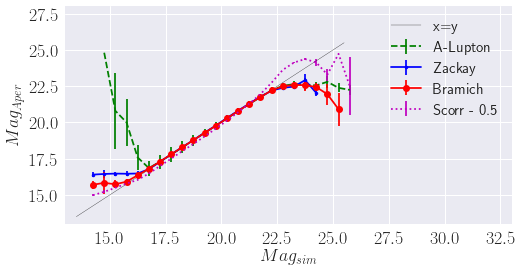

In [56]:
plt.figure(figsize=(8,4))
bins = np.arange(14, 26.5, .5)

# mean_sim, stdv_sim, _ = binning(dt_hot['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning(dt_hot, bins=bins)
plt.errorbar(mean_sim[sqrtn!=0], mean_det[sqrtn!=0], yerr=stdv_det[sqrtn!=0], fmt='g--', label='A-Lupton')

# mean_sim, stdv_sim, _ = binning(dt_zps['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning(dt_zps, bins=bins)
plt.errorbar(mean_sim[sqrtn!=0], mean_det[sqrtn!=0], yerr=stdv_det[sqrtn!=0], fmt='b.-', label='Zackay')

# mean_sim, stdv_sim, _ = binning(dt_ois['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning(dt_ois, bins=bins)
plt.errorbar(mean_sim[sqrtn!=0], mean_det[sqrtn!=0], yerr=stdv_det[sqrtn!=0], fmt='ro-', label='Bramich')

# mean_sim, stdv_sim, _ = binning(dt_sps['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning(dt_sps, bins=bins)
plt.errorbar(mean_sim, mean_det, yerr=stdv_det/sqrtn, fmt='m:', label='Scorr - 0.5')

plt.plot(np.arange(13.5, 26, 0.5), np.arange(13.5, 26, 0.5), color='k', label='x=y', linewidth=0.3)

plt.tick_params(labelsize=18)
plt.ylabel('$Mag_{Aper}$', fontsize=18)
plt.xlabel('$Mag_{sim}$', fontsize=18)
#plt.title('Simulated Mag vs Detected Aperture Mag', fontsize=14)
plt.legend(loc='best', fontsize=15)

plt.xlim(13, 33)
plt.ylim(13, 28)
plt.savefig(os.path.join(plot_dir, 'corrected_aper_vs_simulated_mag.png'), format='png', dpi=900)

In [57]:
def binning_res(data, bins, return_center_bins=False):
    mean = np.zeros_like(bins[:-1])
    stdv = np.zeros_like(bins[:-1])
    sqrtn= np.zeros_like(mean)
    mean_sim_mag = np.zeros_like(mean)
    for i_bin, low in enumerate(bins[:-1]):
        high = bins[i_bin+1]
        f1data = data[data['mag']<25]
        fdata = f1data[(f1data['sim_mag'] < high) * (f1data['sim_mag'] >= low)]
        fdata_mag = fdata['mag'] - fdata['sim_mag']
        if len(fdata) is 0:
            sqrtn[i_bin] = 0
            mean[i_bin] = np.median(fdata_mag)
            stdv[i_bin] = np.std(fdata_mag)
            continue
        mean_sim_mag[i_bin] = (high+low)/2.
        sqrtn[i_bin] = np.sqrt(len(fdata_mag))
        mean[i_bin] = np.median(fdata_mag)
        stdv[i_bin] = np.std(fdata_mag)
    if return_center_bins:
        return bins[:-1]+(high-low)*0.5, mean, stdv, sqrtn
    else:
        return mean, stdv, sqrtn, mean_sim_mag

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


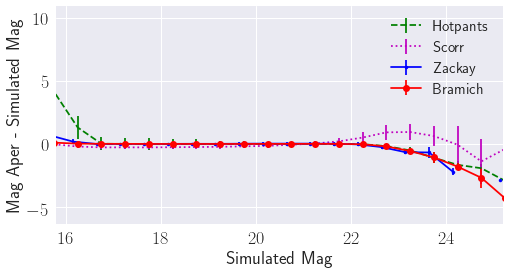

In [58]:
plt.figure(figsize=(8,4))
bins = np.arange(14, 26.5, .5)

#mean_sim, stdv_sim, _ = binning(dt_hot['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_hot, bins=bins)
plt.errorbar(mean_sim, mean_det, yerr=stdv_det, fmt='g--', label='Hotpants')

# mean_sim, stdv_sim, _ = binning(dt_sps['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_sps, bins=bins)
plt.errorbar(mean_sim, mean_det, yerr=stdv_det, fmt='m:', label='Scorr')

# mean_sim, stdv_sim, _ = binning(dt_zps['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_zps, bins=bins)
plt.errorbar(mean_sim-0.1, mean_det, yerr=stdv_det, fmt='b.-', label='Zackay')

# mean_sim, stdv_sim, _ = binning(dt_ois['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_ois, bins=bins)
plt.errorbar(mean_sim, mean_det, yerr=stdv_det, fmt='ro-', label='Bramich')

#plt.plot(np.arange(13.5, 26, 0.5), np.arange(13.5, 26, 0.5), color='k', label='x=y', linewidth=0.3)

plt.tick_params(labelsize=18)
plt.ylabel('Mag Aper - Simulated Mag', fontsize=18)
plt.xlabel('Simulated Mag', fontsize=18)
#plt.title('Simulated Mag vs Detected Aperture Mag', fontsize=14)
plt.legend(loc='best', fontsize=15)

plt.xlim(15.8, 25.2)
#plt.ylim(-2., 2.5)
plt.savefig(os.path.join(plot_dir, 'corrected_aper_diff_vs_simulated_mag.png'), format='png', dpi=480)

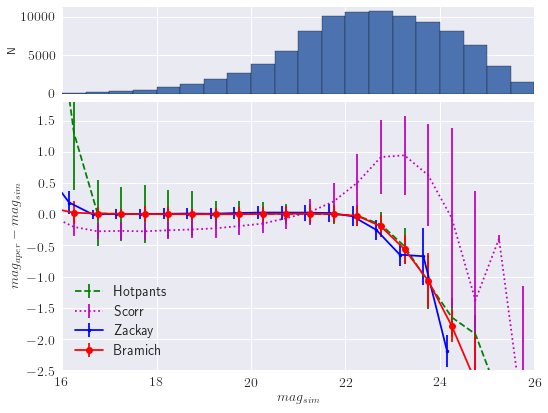

In [59]:
from matplotlib.ticker import NullFormatter

nullfmt = NullFormatter()

left, width = 0.12, 0.82
bottom, height = 0.12, 0.62
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
# rect_scatter = [0.15, 0.1, 0.85, 0.65]
rect_histx = [left, bottom_h, width, 0.2]
# rect_histx = [0.15, 0.77, 0.85, 0.2]
# rect_histy = [left_h, bottom, 0.2, height]

plt.figure(1, figsize=(8, 6))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
# axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)

# the scatter plot:
bins = np.arange(14, 26.5, .5)

#mean_sim, stdv_sim, _ = binning(dt_hot['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_hot, bins=bins)
axScatter.errorbar(mean_sim, mean_det, yerr=stdv_det, fmt='g--', label='Hotpants')

# mean_sim, stdv_sim, _ = binning(dt_sps['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_sps, bins=bins)
axScatter.errorbar(mean_sim, mean_det, yerr=stdv_det, fmt='m:', label='Scorr')

# mean_sim, stdv_sim, _ = binning(dt_zps['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_zps, bins=bins)
axScatter.errorbar(mean_sim-0.1, mean_det, yerr=stdv_det, fmt='b.-', label='Zackay')

# mean_sim, stdv_sim, _ = binning(dt_ois['sim_mag'], bins=bins)
mean_det, stdv_det, sqrtn, mean_sim = binning_res(dt_ois, bins=bins)
axScatter.errorbar(mean_sim, mean_det, yerr=stdv_det, fmt='ro-', label='Bramich')

axScatter.set_xlim((16., 26))
axScatter.set_ylim((-2.5, 1.8))
axScatter.tick_params(labelsize=14)
axScatter.set_ylabel('$mag_{aper} - mag_{sim}$', fontsize=14)
axScatter.set_xlabel('$mag_{sim}$', fontsize=14)

axScatter.legend(loc='best', fontsize=14)
# bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(np.asarray(simulated['app_mag']), bins=bins, log=False)
# axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.tick_params(labelsize=14)
axHistx.set_xlim(axScatter.get_xlim())
axHistx.set_ylabel('N')
# axHisty.set_ylim(axScatter.get_ylim())

plt.savefig(os.path.join(plot_dir,'diff_vs_sim_margin.pdf'), format='pdf', dpi=420)

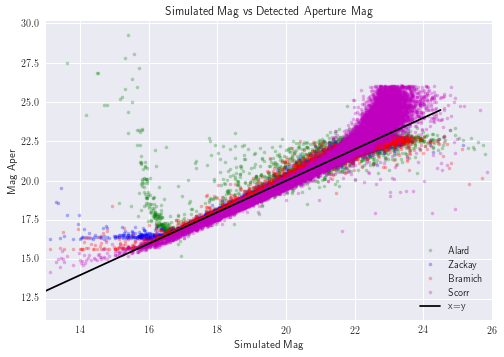

In [60]:
plt.plot(dt_hot['sim_mag'], dt_hot['mag'], 'g.', label='Alard', alpha=0.3)
plt.plot(dt_zps['sim_mag'], dt_zps['mag'], 'b.', label='Zackay', alpha=0.3)
plt.plot(dt_ois['sim_mag'], dt_ois['mag'], 'r.', label='Bramich', alpha=0.3)
plt.plot(dt_sps['sim_mag'], dt_sps['mag'], 'm.', label='Scorr', alpha=0.3)

plt.plot(np.arange(12, 25, 0.5), np.arange(12, 25, 0.5), color='k', label='x=y')

plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')
plt.xlim(13, 26)
plt.savefig(os.path.join(plot_dir, 'corrected_aper_vs_simulated_mag_scatter.png'), format='png', dpi=900)

In [61]:
dt_ois['mu'] = dt_ois.mag/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['mu'] = dt_zps.mag/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)
dt_hot['mu'] = dt_hot.mag/(dt_hot.A_IMAGE*dt_hot.B_IMAGE)
dt_sps['mu'] = dt_sps.mag/(dt_sps.a*dt_sps.b)

In [62]:
dt_ois['sn'] = dt_ois.FLUX_APER/dt_ois.FLUXERR_APER
dt_zps['sn'] = dt_zps.FLUX_APER/dt_zps.FLUXERR_APER
dt_hot['sn'] = dt_hot.FLUX_APER/dt_hot.FLUXERR_APER
dt_sps['sn'] = dt_sps.cflux/np.sqrt(dt_sps.cflux)

In [63]:
bogus_s = dt_sps[dt_sps.IS_REAL==False]
reals_s = dt_sps[dt_sps.IS_REAL==True]

bogus_b = dt_ois[dt_ois.IS_REAL==False]
reals_b = dt_ois[dt_ois.IS_REAL==True]

bogus_z = dt_zps[dt_zps.IS_REAL==False]
reals_z = dt_zps[dt_zps.IS_REAL==True]

bogus_h = dt_hot[dt_hot.IS_REAL==False]
reals_h = dt_hot[dt_hot.IS_REAL==True]

In [64]:
print len(bogus_b), len(bogus_z), len(bogus_h), len(bogus_s)

112385 11081 69089 50873


In [65]:
print len(reals_b), len(reals_z), len(reals_h), len(reals_s)

47646 44676 49722 35803


## Luminosity function 

Bogus, Real, and FN luminosity functions.


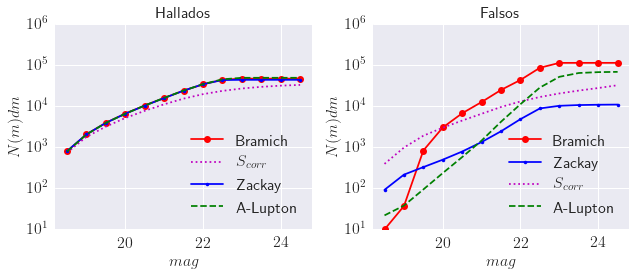

In [66]:
plt.figure(figsize=(9,4))

#magnitude bins
bins = np.arange(18, 25, 0.5)

plt.subplot(121)
cumulative=True
x_bins, vals = custom_histogram(reals_b.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')

x_bins, vals = custom_histogram(reals_s.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'm:', label='$S_{corr}$')

x_bins, vals = custom_histogram(reals_z.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')

x_bins, vals = custom_histogram(reals_h.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='A-Lupton')
plt.ylim(1e1, 1e6)
#plt.xlim(18, 24.5)
plt.title('Hallados', fontsize=16)
plt.ylabel(r'$N(m)dm$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xlabel(r'$mag$', fontsize=16)
#plt.ylim(50, 280000)
plt.tick_params(labelsize=16)

plt.subplot(122)
x_bins, vals = custom_histogram(bogus_b.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(bogus_s.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'm:', label='$S_{corr}$')
x_bins, vals = custom_histogram(bogus_h.mag.values, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='A-Lupton')
#plt.xlim(20, 24.5)
plt.ylim(1e1, 1e6)
plt.ylabel(r'$N(m)dm$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xlabel(r'$mag$', fontsize=16)
plt.title('Falsos', fontsize=16)
#plt.ylim(50, 280000)
plt.tick_params(labelsize=16)

plt.tight_layout()
#plt.show()

plt.savefig(os.path.join(plot_dir, 'luminosities_functions.png'), format='png', dpi=700)

In [67]:
simulated.columns

Index([u'id', u'code', u'x', u'y', u'app_mag', u'r_scales', u'gx_mag',
       u'image_id', u'simage_id', u'scorrimage_id', u'image_id_ois',
       u'image_id_hot'],
      dtype='object')

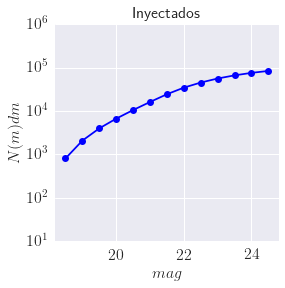

In [68]:
plt.figure(figsize=(4,4))
bins = np.arange(18, 25, 0.5)
plt.title('Inyectados', fontsize=16)
xbins, vals =custom_histogram(simulated['app_mag'], bins=bins, cumulative=True)
plt.semilogy(x_bins, vals, 'b-o', label='Inyectados')
plt.ylim(1e1, 1e6)
plt.xlabel(r'$mag$', fontsize=16)
#plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)
plt.ylabel(r'$N(m) dm$', fontsize=16)
#plt.ylabel(r'$\int_{-\infty}^{mag}\phi(m\prime)dm\prime$', fontsize=16)
plt.savefig(os.path.join(plot_dir, 'lum_fun_simulated.png'), dpi=400)

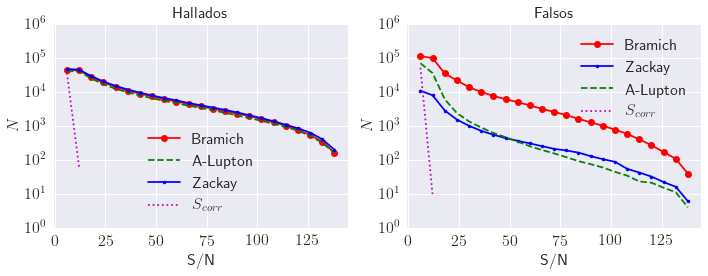

In [69]:
#signal to noise bins
plt.figure(figsize=(10,4))

bins = np.arange(0, 140, 6)
cumulative=-1
plt.subplot(121)
plt.title('Hallados', fontsize=16)
x_bins, vals = custom_histogram(reals_b.sn, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z.sn, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='A-Lupton')
x_bins, vals = custom_histogram(reals_h.sn,
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(reals_s.sn,
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'm:', label='$S_{corr}$')
plt.ylim(1, 10e5)
#plt.xlim(110, 0)
#plt.title('Cummulative S/N function Reals')#, fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.ylabel(r'$N$', fontsize=16)
plt.xlabel('S/N', fontsize=16)
plt.tick_params(labelsize=16)

plt.subplot(122)
plt.title('Falsos', fontsize=16)
x_bins, vals = custom_histogram(bogus_b.sn, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.sn,
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h.sn, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='A-Lupton')
x_bins, vals = custom_histogram(bogus_s.sn, 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'm:', label='$S_{corr}$')
plt.ylim(1, 10e5)
#plt.xlim(70, 0)
plt.tick_params(labelsize=16)
#plt.title('Cummulative S/N function Bogus')#, fontsize=16)
plt.ylabel(r'$N$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xlabel('S/N', fontsize=16)

plt.tight_layout()
#plt.show()

plt.savefig(os.path.join(plot_dir, 'sn_functions.png'), format='png', dpi=700)

## What about the FN?

We should check on the lost objects.

### Luminosity function for Undetected

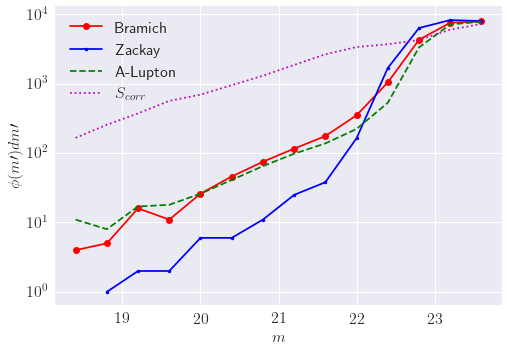

In [70]:
bins = np.arange(18, 24, 0.4)

plt.figure()
cumulative=False
x_bins, vals = custom_histogram(und_b.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay')
x_bins, vals = custom_histogram(und_h.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g--', label='A-Lupton')
x_bins, vals = custom_histogram(und_s.app_mag, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'm:', label='$S_{corr}$')

plt.legend(loc='upper left', fontsize=16)
if cumulative:
    plt.ylabel(r'$\int_{-\infty}^{m}\phi(m\prime)dm\prime$', fontsize=16)
else:
    plt.ylabel(r'$\phi(m\prime)dm\prime$', fontsize=16)
plt.xlabel(r'$m$', fontsize=16)
#plt.title('Cummulative Luminosity Function of False Negatives', fontsize=14)
plt.tick_params(labelsize=16)
#plt.xlim(21., 23.1)
#plt.show()
#plt.ylim(100, 13e3)
plt.savefig(os.path.join(plot_dir, 'lum_function_FNegatives.png'), format='png', dpi=700)

### Are there coincident objects?

In [71]:
und_b.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [72]:
und_z.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [73]:
und_mix = pd.merge(left=und_b, right=und_z, on='simulated_id', 
                   suffixes=('_b', '_z'), how='outer', indicator='lisb_risz')

In [74]:
und_h.columns

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object')

In [75]:
und_mix.columns

Index([         u'x_b',          u'y_b',    u'app_mag_b',   u'image_id_b',
       u'simulated_id',          u'x_z',          u'y_z',    u'app_mag_z',
         u'image_id_z',    u'lisb_risz'],
      dtype='object')

In [76]:
und_mix = pd.merge(left=und_mix, right=und_h, on='simulated_id', 
                   suffixes=('', '_h'), how='outer', indicator='lismix_rish')

In [77]:
und_mix.columns

Index([         u'x_b',          u'y_b',    u'app_mag_b',   u'image_id_b',
       u'simulated_id',          u'x_z',          u'y_z',    u'app_mag_z',
         u'image_id_z',    u'lisb_risz',            u'x',            u'y',
            u'app_mag',     u'image_id',  u'lismix_rish'],
      dtype='object')

In [78]:
case = [] 
for _, row in und_mix.iterrows():
    
    if row['lismix_rish']=='both':
        if row['lisb_risz']=='both':
            case.append('all')
        elif row['lisb_risz']=='left_only':
            case.append('b_and_h')
        else:
            case.append('z_and_h')
    
    elif row['lismix_rish']=='left_only':
        if row['lisb_risz']=='both':
            case.append('b_and_z')
        elif row['lisb_risz']=='left_only':
            case.append('only_b')
        else:
            case.append('only_z')
    
    elif row['lismix_rish']=='right_only':
        case.append('only_h')

und_mix['origin'] = case

In [79]:
magnitudes_und = pd.DataFrame({#'mag_all'    : und_mix[und_mix.origin=='all'].app_mag,
                               r'mag_onlyb'  : und_mix[und_mix.origin=='only_b'].app_mag_b,
                               r'mag_onlyz'  : und_mix[und_mix.origin=='only_z'].app_mag_z,
                               r'mag_onlyh'  : und_mix[und_mix.origin=='only_h'].app_mag,
                               r'mag_b_and_h': und_mix[und_mix.origin=='b_and_h'].app_mag,
                               r'mag_z_and_h': und_mix[und_mix.origin=='z_and_h'].app_mag,
                               r'mag_b_and_z': und_mix[und_mix.origin=='b_and_z'].app_mag_b})

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(1.0, 10000)

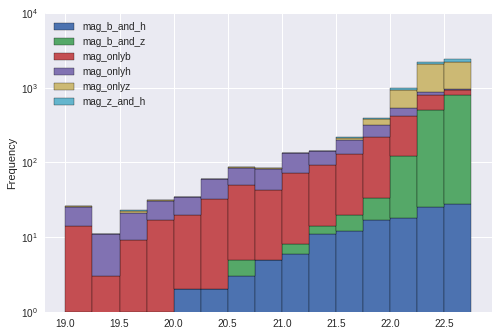

In [80]:
bins = np.arange(19, 23., 0.25)
plt.figure(figsize=(10, 10))
plt.rcParams['text.usetex'] = False
magnitudes_und.plot.hist(stacked=True, bins=bins, log=True)
plt.legend(loc='upper left')
plt.ylim(0, 10000)

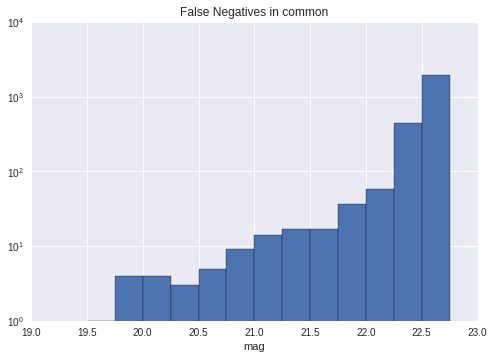

In [81]:
bins = np.arange(19, 23., 0.25)
plt.hist(und_mix.app_mag[und_mix.origin=='all'], bins=bins, log=True)
plt.title('False Negatives in common')
plt.xlabel('mag')
plt.xlim(19, 23.)
plt.ylim(1, 10000)
plt.show()

In [82]:
plt.rcParams['text.usetex'] = True

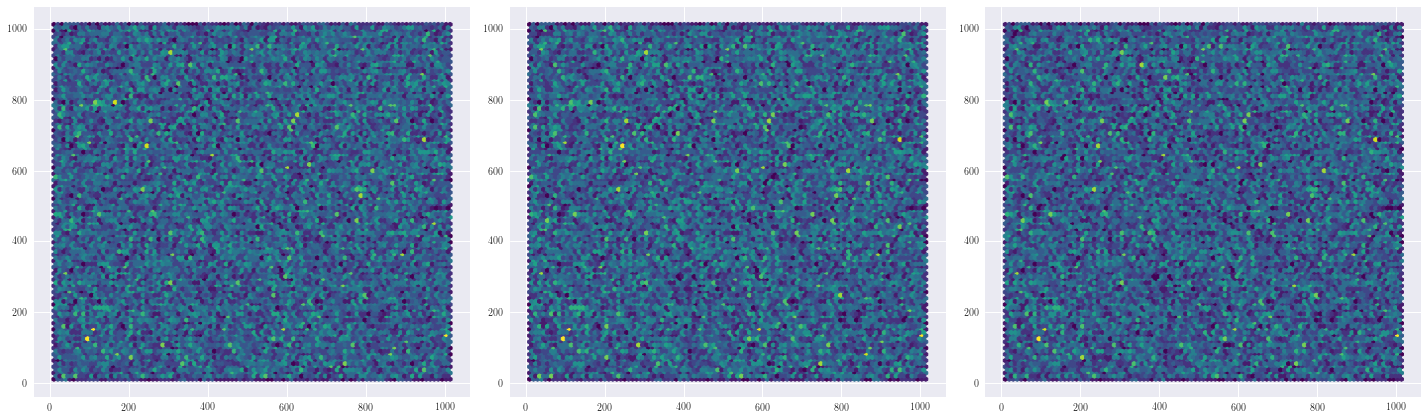

In [83]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.hexbin(und_z.x, und_z.y, cmap='viridis')
#plt.colorbar()
plt.subplot(132)
plt.hexbin(und_b.x, und_b.y, cmap='viridis')
#plt.colorbar()
plt.subplot(133)
plt.hexbin(und_h.x, und_h.y, cmap='viridis')
#plt.colorbar()
plt.tight_layout()
plt.show()

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


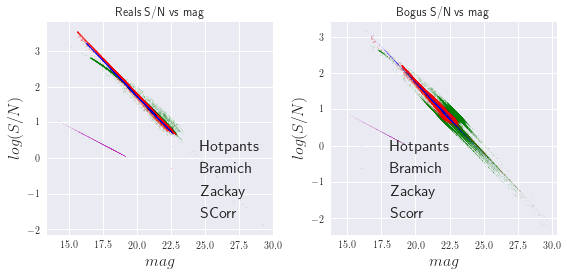

In [84]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_h.mag, 
         np.log10(reals_h.sn), 
         s=np.log10(reals_h.FLUXERR_ISO), linewidths=0.001,
         c='g', marker='.', alpha=0.3, label='Hotpants')
plt.scatter(reals_b.mag, 
         np.log10(reals_b.sn),
         s=np.log10(reals_b.FLUXERR_ISO), linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag, 
         np.log10(reals_z.sn), 
         s=np.log10(reals_z.FLUXERR_ISO), linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.scatter(reals_s.mag, 
         np.log10(reals_s.sn), 
         s=np.log10(np.sqrt(reals_s.cflux)), linewidths=0.001,
         c='m', marker='.', alpha=0.3, label='SCorr')

# plt.xlim(18,25)
# plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$', fontsize=16)
plt.ylabel(r'$log(S/N)$', fontsize=16)
plt.legend(loc='best', fontsize=16)


plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_h.mag,
            np.log10(bogus_h.sn),
            s=np.log10(bogus_h.FLUXERR_ISO), linewidths=0.001,
            c='g', marker='.', alpha=0.3, label='Hotpants')
plt.scatter(bogus_b.mag,
            np.log10(bogus_b.sn),
            s=np.log10(bogus_b.FLUXERR_ISO), linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag,
            np.log10(bogus_z.sn),
            s=np.log10(bogus_z.FLUXERR_ISO), linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.scatter(bogus_s.mag,
            np.log10(bogus_s.sn),
            s=np.log10(np.sqrt(bogus_s.cflux)), linewidths=0.001,
            c='m', marker='.', alpha=0.3, label='Scorr')

# plt.xlim(18,25)
# plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$', fontsize=16)
plt.ylabel(r'$log(S/N)$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

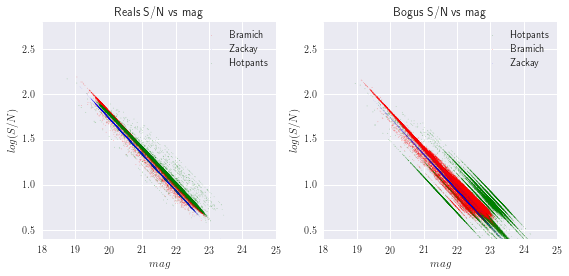

In [85]:
low_cstar_b = reals_b.CLASS_STAR < 0.005
low_cstar_z = reals_z.CLASS_STAR < 0.005
low_cstar_h = reals_h.CLASS_STAR < 0.005

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals S/N vs mag')
plt.scatter(reals_b.mag[low_cstar_b], 
         np.log10(reals_b.sn)[low_cstar_b],
         s=np.log10(reals_b.FLUXERR_ISO)[low_cstar_b], linewidths=0.001, 
        c='r', marker='.', alpha=0.3, label='Bramich')
plt.scatter(reals_z.mag[low_cstar_z], 
         np.log10(reals_z.sn)[low_cstar_z], 
         s=np.log10(reals_z.FLUXERR_ISO)[low_cstar_z], linewidths=0.001,
         c='b', marker='.', alpha=0.3, label='Zackay')
plt.scatter(reals_h.mag[low_cstar_h], 
         np.log10(reals_h.sn)[low_cstar_h],
         s=np.log10(reals_h.FLUXERR_ISO)[low_cstar_h], linewidths=0.001, 
        c='g', marker='.', alpha=0.3, label='Hotpants')
plt.xlim(18,25)
plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')

low_cstar_b = bogus_b.CLASS_STAR < 0.005
low_cstar_z = bogus_z.CLASS_STAR < 0.005
low_cstar_h = bogus_h.CLASS_STAR < 0.005

plt.subplot(122)
plt.title('Bogus S/N vs mag')
plt.scatter(bogus_h.mag[low_cstar_h],
            np.log10(bogus_h.sn)[low_cstar_h],
            s=np.log10(bogus_h.FLUXERR_ISO)[low_cstar_h], linewidths=0.001,
            c='g', marker='.', alpha=0.3, label='Hotpants')
plt.scatter(bogus_b.mag[low_cstar_b],
            np.log10(bogus_b.sn)[low_cstar_b],
            s=np.log10(bogus_b.FLUXERR_ISO)[low_cstar_b], linewidths=0.001,
            c='r', marker='.', alpha=0.3, label='Bramich') 
plt.scatter(bogus_z.mag[low_cstar_z],
            np.log10(bogus_z.sn)[low_cstar_z],
            s=np.log10(bogus_z.FLUXERR_ISO)[low_cstar_z], linewidths=0.001,
            c='b', marker='.', alpha=0.3, label='Zackay')
plt.xlim(18,25)
plt.ylim(0.4, 2.8)
plt.xlabel(r'$mag$')
plt.ylabel(r'$log(S/N)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag.png'), format='png', dpi=700)

Need to calculate mean and dispersion of log10(S/N) on magnitude bins.

In [86]:
def logsn_binning(data, bins, step):
    meanlogsn = []
    stdvlogsn = []
    
    for abin in bins:
        fdata = data[(data.mag < abin + step) * (data.mag >= abin)]
        meanlogsn.append(np.mean(np.log10(fdata.sn)))
        stdvlogsn.append(np.std( np.log10(fdata.sn)))
    return meanlogsn, stdvlogsn

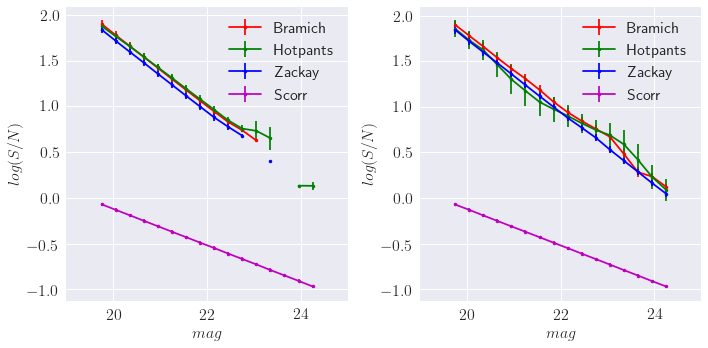

In [87]:
step = 0.3
bins = np.arange(19.6, 24.4, step)

plt.figure(figsize=(10, 5))
plt.subplot(121)
#plt.title('Reals S/N vs mag')
means, stds = logsn_binning(reals_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001, 
             c='r', marker='.', alpha=1, label='Bramich')
means, stds = logsn_binning(reals_h, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001, 
             c='g', marker='.', alpha=1, label='Hotpants')
means, stds = logsn_binning(reals_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             c='b', marker='.', alpha=1, label='Zackay')
means, stds = logsn_binning(reals_s, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             c='m', marker='.', alpha=1, label='Scorr')
plt.xlim(19,25)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$', fontsize=16)
plt.ylabel(r'$log(S/N)$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)

plt.subplot(122)
#plt.title('Bogus S/N vs mag')
means, stds = logsn_binning(bogus_b, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
            #linewidths=0.001,
            c='r', marker='.', alpha=1, label='Bramich') 
means, stds = logsn_binning(bogus_h, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
            #linewidths=0.001,
            c='g', marker='.', alpha=1, label='Hotpants') 
means, stds = logsn_binning(bogus_z, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001,
             c='b', marker='.', alpha=1, label='Zackay')
means, stds = logsn_binning(bogus_s, bins, step)
plt.errorbar(x=bins + step/2., 
             y=means,
             yerr=stds, 
             #linewidths=0.001,
             c='m', marker='.', alpha=1, label='Scorr')
plt.xlim(19,25)
plt.tick_params(labelsize=16)
#plt.ylim(0, 220)
plt.xlabel(r'$mag$', fontsize=16)
plt.ylabel(r'$log(S/N)$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'signal_to_noise_vs_mag_binned.png'), format='png', dpi=700)

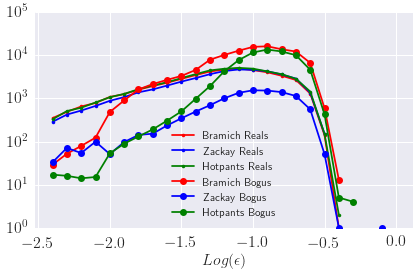

In [88]:
bins=np.arange(-2.5, 0.1, 0.1)
plt.figure(figsize=(6, 4))
#plt.subplot(121)
#plt.title('Reals')
# plt.hist([np.log10(reals_b.MAGERR_ISO[reals_b.MAG_ISO < 30]),
#           np.log10(reals_h.MAGERR_ISO[reals_h.MAG_ISO < 30]),
#           np.log10(reals_z.MAGERR_ISO[reals_z.MAG_ISO < 30])],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'], 
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(np.log10(reals_b.MAGERR_ISO[reals_b.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'r.-', label='Bramich Reals')
x_bins, vals = custom_histogram(np.log10(reals_z.MAGERR_ISO[reals_z.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'b.-', label='Zackay Reals')
x_bins, vals = custom_histogram( np.log10(reals_h.MAGERR_ISO[reals_h.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'g.-', label='Hotpants Reals')


plt.xlabel(r'$Log(\epsilon)$', fontsize=16)
#plt.xlim(-3.5, 0.)
plt.ylim(0, 10e4)
# plt.legend(loc='best')

# plt.subplot(122)
# plt.title('Bogus')
# plt.hist([np.log10(bogus_b.MAGERR_ISO[bogus_b.MAG_ISO < 30]),
#           np.log10(bogus_h.MAGERR_ISO[bogus_h.MAG_ISO < 30]),
#           np.log10(bogus_z.MAGERR_ISO[bogus_z.MAG_ISO < 30])],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'], 
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(np.log10(bogus_b.MAGERR_ISO[bogus_b.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich Bogus')
x_bins, vals = custom_histogram(np.log10(bogus_z.MAGERR_ISO[bogus_z.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay Bogus')
x_bins, vals = custom_histogram(np.log10(bogus_h.MAGERR_ISO[bogus_h.MAG_ISO < 30]), 
                                bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants Bogus')

#plt.xlabel(r'$Log(\epsilon)$')
#plt.xlim(-3.5, 0.)
#plt.ylim(0, 100000)
plt.legend(loc='best', fontsize=11)
plt.tick_params(labelsize=16)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'mag_errors.png'), format='png', dpi=700)

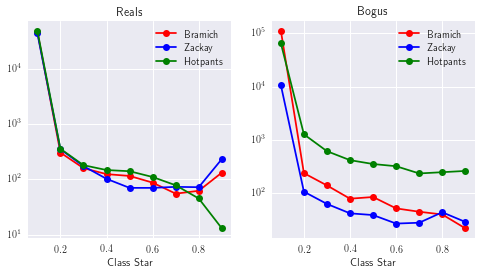

In [89]:
bins = np.arange(0, 1., 0.1)
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
# plt.hist([reals_b.CLASS_STAR, reals_h.CLASS_STAR, reals_z.CLASS_STAR],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(reals_b.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'Class Star')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
# plt.hist([bogus_b.CLASS_STAR, bogus_h.CLASS_STAR, bogus_z.CLASS_STAR],
#          color=['red', 'green', 'blue'],
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(bogus_b.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h.CLASS_STAR, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'Class Star')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'class_star_hist.png'), format='png', dpi=700)

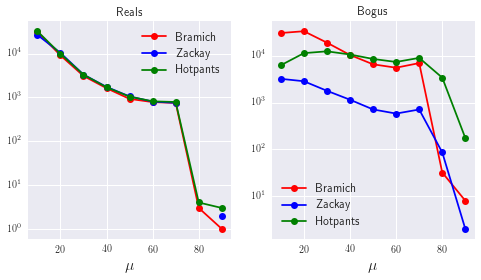

In [90]:
bins = np.arange(0, 100, 10)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
# plt.hist([reals_b.mu, reals_h.mu, reals_z.mu],
#          color=['red', 'green', 'blue'], bins=bins,
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(reals_b.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$\mu$', fontsize=16)
plt.legend(loc='best', fontsize=12)

plt.subplot(122)
plt.title('Bogus')
# plt.hist([bogus_b.mu, bogus_h.mu, bogus_z.mu],
#          color=['red', 'green', 'blue'], bins=bins,
#          label=['Bramich', 'Hotpants', 'Zackay'],
#          log=True, alpha=0.6)
cumulative=False
x_bins, vals = custom_histogram(bogus_b.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h.mu, bins=bins, cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$\mu$', fontsize=16)
plt.legend(loc='best', fontsize=12)

plt.savefig(os.path.join(plot_dir, 'mu_hist.png'), format='png', dpi=700)

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


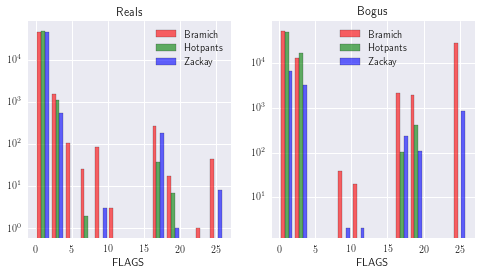

In [91]:
bins = np.arange(0, 28, 2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist([reals_b.FLAGS, reals_h.FLAGS, reals_z.FLAGS],
         color=['red', 'green', 'blue'], bins=bins,
         label=['Bramich', 'Hotpants', 'Zackay'],
         log=True, alpha=0.6)
plt.xlabel(r'FLAGS')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.hist([bogus_b.FLAGS, bogus_h.FLAGS, bogus_z.FLAGS],
         color=['red', 'green', 'blue'], bins=bins,
         label=['Bramich', 'Hotpants', 'Zackay'],
         log=True, alpha=0.6)
plt.xlabel(r'FLAGS')
plt.legend(loc='best')

plt.savefig(os.path.join(plot_dir, 'flags_hist.png'), format='png', dpi=700)

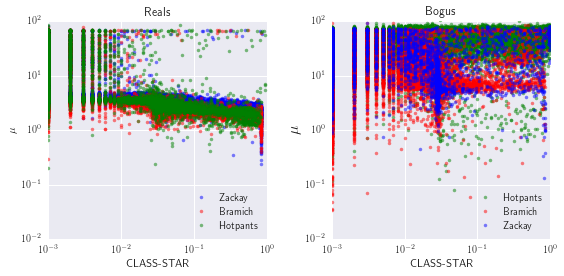

In [92]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.plot(reals_z.CLASS_STAR, reals_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')
plt.plot(reals_b.CLASS_STAR, reals_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(reals_h.CLASS_STAR, reals_h.mu, '.',
            alpha=0.5, color='green', label='Hotpants')

plt.xlim(0.001, 1.)
plt.ylim(0.01, 100)
plt.loglog()
plt.xlabel(r'CLASS-STAR')
plt.ylabel(r'$\mu$')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Bogus')
plt.plot(bogus_h.CLASS_STAR, bogus_h.mu, '.', 
            alpha=0.5, color='green', label='Hotpants')
plt.plot(bogus_b.CLASS_STAR, bogus_b.mu, '.',
            alpha=0.5, color='red', label='Bramich')
plt.plot(bogus_z.CLASS_STAR, bogus_z.mu, '.', 
            alpha=0.5, color='blue', label='Zackay')


plt.xlim(0.001, 1.)
plt.ylim(0.01, 100)
plt.loglog()
plt.xlabel(r'CLASS-STAR')
plt.ylabel(r'$\mu$', fontsize=16)
plt.legend(loc='best')
plt.tight_layout()

## Simulation parameters

We need data on simulation for every object, specially undetected (there are a lot of these)

In [93]:
sim_pars = pd.read_sql_query("""SELECT * FROM Images""", engine)

In [94]:
sim_pars = sim_pars.merge(simulated, left_on='id', right_on='image_id', 
                          how='right', suffixes=('_img', '_src'))

In [95]:
print und_b.columns, len(und_b), len(sim_pars)

Index([u'x', u'y', u'app_mag', u'image_id', u'simulated_id'], dtype='object') 49145 96792


In [96]:
sim_pars.columns

Index([u'id_img', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'exec_time', u'id_src',
       u'code', u'x', u'y', u'app_mag', u'r_scales', u'gx_mag', u'image_id',
       u'simage_id', u'scorrimage_id', u'image_id_ois', u'image_id_hot'],
      dtype='object')

In [97]:
und_b = pd.merge(left=und_b, right=sim_pars, left_on='simulated_id', right_on='id_src', how='left')
und_z = pd.merge(left=und_z, right=sim_pars, left_on='simulated_id', right_on='id_src', how='left')
und_h = pd.merge(left=und_h, right=sim_pars, left_on='simulated_id', right_on='id_src', how='left')

In [98]:
print und_b.columns, len(und_b)

Index([u'x_x', u'y_x', u'app_mag_x', u'image_id_x', u'simulated_id', u'id_img',
       u'path', u'crossmatched', u'refstarcount_zp', u'refstarcount_slope',
       u'refseeing_fwhm', u'exec_time', u'id_src', u'code', u'x_y', u'y_y',
       u'app_mag_y', u'r_scales', u'gx_mag', u'image_id_y', u'simage_id',
       u'scorrimage_id', u'image_id_ois', u'image_id_hot'],
      dtype='object') 49145


In [99]:
print ' Columns of sim_pars:\n', sim_pars.columns
print '\n Columns of und_b:\n', und_b.columns
print '\n Columns of und_z:\n', und_z.columns
print '\n Columns of und_h:\n', und_h.columns
print '\n Columns of simulated:\n', simulated.columns

 Columns of sim_pars:
Index([u'id_img', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'exec_time', u'id_src',
       u'code', u'x', u'y', u'app_mag', u'r_scales', u'gx_mag', u'image_id',
       u'simage_id', u'scorrimage_id', u'image_id_ois', u'image_id_hot'],
      dtype='object')

 Columns of und_b:
Index([u'x_x', u'y_x', u'app_mag_x', u'image_id_x', u'simulated_id', u'id_img',
       u'path', u'crossmatched', u'refstarcount_zp', u'refstarcount_slope',
       u'refseeing_fwhm', u'exec_time', u'id_src', u'code', u'x_y', u'y_y',
       u'app_mag_y', u'r_scales', u'gx_mag', u'image_id_y', u'simage_id',
       u'scorrimage_id', u'image_id_ois', u'image_id_hot'],
      dtype='object')

 Columns of und_z:
Index([u'x_x', u'y_x', u'app_mag_x', u'image_id_x', u'simulated_id', u'id_img',
       u'path', u'crossmatched', u'refstarcount_zp', u'refstarcount_slope',
       u'refseeing_fwhm', u'exec_time', u'id_src', u'code', u'x_y', u'y_y',
       

In [100]:
bins_fwhm = np.arange(0.8, 1.5, 0.15)
bins_slope = np.arange(0, 1, 0.2)
bins_zp = np.arange(3.5, 5., 0.3)

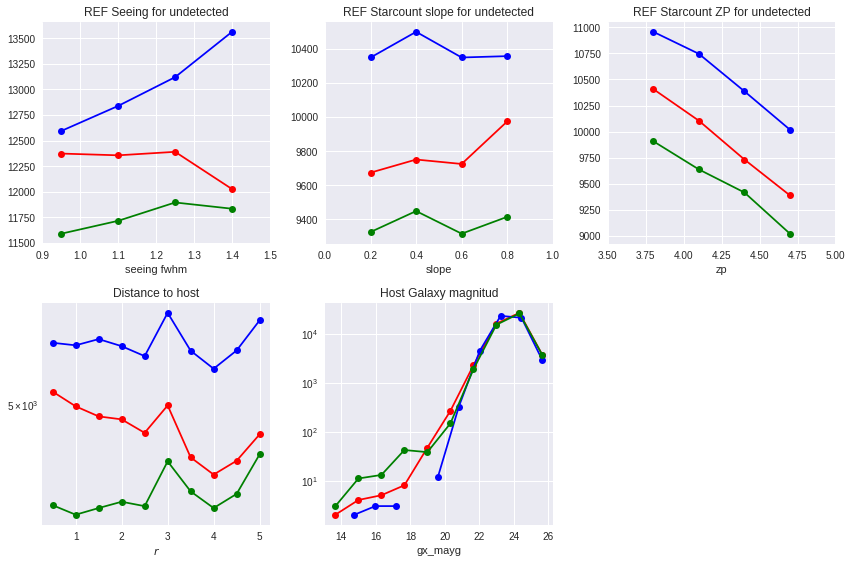

In [101]:
plt.figure(figsize=(12, 8))
plt.rcParams['text.usetex'] = False
plt.subplot(2, 3, 1)
# plt.hist([und_z['refseeing_fwhm'], und_h['refseeing_fwhm'], und_b['refseeing_fwhm']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=True)
cumulative=False
x_bins, vals = custom_histogram(und_b['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('seeing fwhm')
plt.xlim(0.9, 1.5)
plt.title('REF Seeing for undetected')

plt.subplot(2, 3, 2)
# plt.hist([und_z['refstarcount_slope'], und_h['refstarcount_slope'], und_b['refstarcount_slope']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(und_b['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('slope')
plt.xlim(0, 1.)
# plt.ylim(4000, 7000)
plt.title('REF Starcount slope for undetected')

plt.subplot(2, 3, 3)
# plt.hist([np.log10(und_z['refstarcount_zp']), 
#           np.log10(und_h['refstarcount_zp']), 
#           np.log10(und_b['refstarcount_zp'])],
#           color=['blue', 'green', 'red'], 
#           label=['Zackay', 'Hotpants', 'Bramich'],
#           cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(np.log10(und_b['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(np.log10(und_z['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(np.log10(und_h['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
# plt.ylim(4000, 7000)
plt.xlim(3.5, 5)
plt.xlabel('zp')
plt.title('REF Starcount ZP for undetected')

plt.subplot(2, 3, 4)
# plt.hist([und_z['r_scales'], und_h['r_scales'], und_b['r_scales']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(und_b['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$r$')
plt.title('Distance to host')

plt.subplot(2, 3, 5)
# plt.hist([und_z['gx_mag'], und_h['gx_mag'], und_b['gx_mag']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#         cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(und_b['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(und_z['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(und_h['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'gx_mayg')
plt.title('Host Galaxy magnitud')

plt.tight_layout()
plt.show()

### Simulation parameters for reals

In [102]:
sim_pars.columns

Index([u'id_img', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'exec_time', u'id_src',
       u'code', u'x', u'y', u'app_mag', u'r_scales', u'gx_mag', u'image_id',
       u'simage_id', u'scorrimage_id', u'image_id_ois', u'image_id_hot'],
      dtype='object')

In [103]:
reals_b.columns

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',           u'mag',          

In [104]:
reals_b = pd.merge(left=reals_b, right=sim_pars, 
                   left_on='sim_id', right_on='id_src', how='left')
reals_z = pd.merge(left=reals_z, right=sim_pars, 
                   left_on='sim_id', right_on='id_src', how='left')
reals_h = pd.merge(left=reals_h, right=sim_pars, 
                   left_on='sim_id', right_on='id_src', how='left')

In [105]:
reals_b.columns

Index([                u'id',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

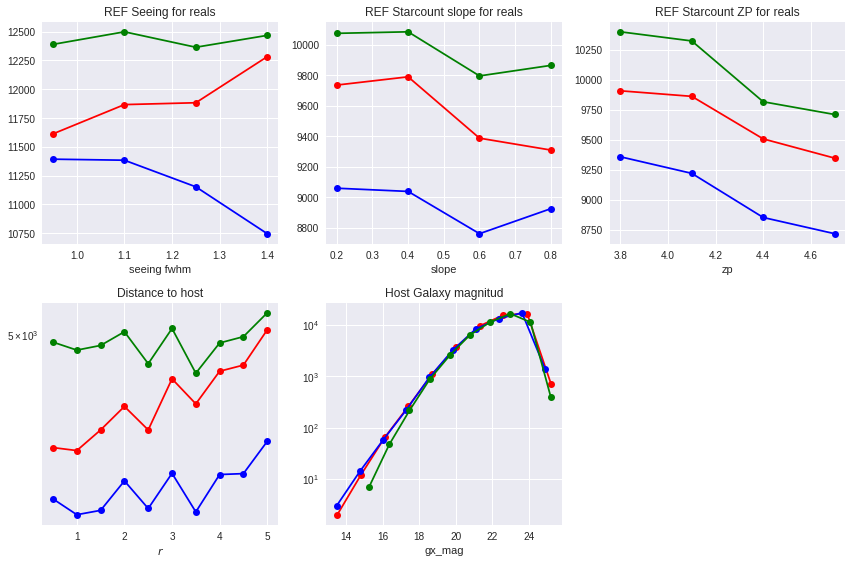

In [106]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
# plt.hist([und_z['refseeing_fwhm'], und_h['refseeing_fwhm'], und_b['refseeing_fwhm']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=True)
cumulative=False
x_bins, vals = custom_histogram(reals_b['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('seeing fwhm')
# plt.ylim(2500, 5000)
plt.title('REF Seeing for reals')

plt.subplot(2, 3, 2)
# plt.hist([und_z['refstarcount_slope'], und_h['refstarcount_slope'], und_b['refstarcount_slope']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(reals_b['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('slope')
# plt.xlim(0, 1.)
# plt.ylim(2500, 5000)
plt.title('REF Starcount slope for reals')

plt.subplot(2, 3, 3)
# plt.hist([np.log10(und_z['refstarcount_zp']), 
#           np.log10(und_h['refstarcount_zp']), 
#           np.log10(und_b['refstarcount_zp'])],
#           color=['blue', 'green', 'red'], 
#           label=['Zackay', 'Hotpants', 'Bramich'],
#           cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(np.log10(reals_b['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(np.log10(reals_z['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(np.log10(reals_h['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
# plt.ylim(2500, 5000)
# plt.xlim(3, 6)
plt.xlabel('zp')
plt.title('REF Starcount ZP for reals')

plt.subplot(2, 3, 4)
# plt.hist([und_z['r_scales'], und_h['r_scales'], und_b['r_scales']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(reals_b['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['r_scales'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'$r$')
plt.title('Distance to host')

plt.subplot(2, 3, 5)
# plt.hist([und_z['gx_mag'], und_h['gx_mag'], und_b['gx_mag']],
#          color=['blue', 'green', 'red'], log=True, 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#         cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(reals_b['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(reals_z['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(reals_h['gx_mag'], cumulative=cumulative)
plt.semilogy(x_bins, vals, 'go-', label='Hotpants')

plt.xlabel(r'gx_mag')
plt.title('Host Galaxy magnitud')

plt.tight_layout()
plt.show()

### Simulation parameters for bogus

In [107]:
sim_pars = pd.read_sql_query("""SELECT * FROM Images""", engine)

In [108]:
sim_pars.columns

Index([u'id', u'path', u'crossmatched', u'refstarcount_zp',
       u'refstarcount_slope', u'refseeing_fwhm', u'exec_time'],
      dtype='object')

In [109]:
print bogus_b.columns, len(bogus_b), len(sim_pars)

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',           u'mag',          

In [110]:
tl = bogus_b.sample(200)
tr = sim_pars.sample(200)

In [111]:
pd.merge(left=tl, right=tr, left_on='image_id', right_on='id', how='left')

,id_x,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,mag,mu,sn,id_y,path,crossmatched,refstarcount_zp,refstarcount_slope,refseeing_fwhm,exec_time
0,84734,98,1351.7770,225.7242,17.1727,0.1813,2418.962,354.0346,16.5409,0.1589,...,22.400608,40.369603,6.832558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97207,117,2260.6900,267.1041,16.6144,0.1283,2517.947,314.9110,16.4974,0.1358,...,22.357108,22.118319,7.995742,752.0,/home/bruno/Data/NewRBpipeline/images/img00752...,1.0,16000.0,0.7,0.8,4.116857
2,121186,30,28904.7600,444.6200,13.8476,0.0167,22040.500,343.7047,14.1419,0.0169,...,20.001608,11.686869,64.126269,940.0,/home/bruno/Data/NewRBpipeline/images/img00940...,1.0,16000.0,0.1,0.8,9.530560
3,108934,192,1218.8460,206.0271,17.2851,0.1836,2117.845,344.7493,16.6853,0.1768,...,22.545008,34.112844,6.143145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,159514,107,2633.3140,282.6427,16.4487,0.1166,3189.360,347.7592,16.2407,0.1184,...,22.100408,24.332153,9.171174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,125105,4,4871.2700,344.0665,15.7809,0.0767,3999.092,311.3845,15.9951,0.0846,...,21.854808,13.968214,12.842939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,77877,54,4305.6930,262.7527,15.9149,0.0663,3669.425,367.4782,16.0885,0.1088,...,21.948208,37.429242,9.985422,604.0,/home/bruno/Data/NewRBpipeline/images/img00604...,1.0,4000.0,0.3,0.8,4.286178
7,127965,125,15067.1600,495.8027,14.5549,0.0357,10799.400,342.1030,14.9165,0.0344,...,20.776208,8.652463,31.567686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,146138,75,22020.6100,643.8820,14.1429,0.0318,9946.577,344.2193,15.0058,0.0376,...,20.865508,4.983361,28.896047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87094,33,1321.6870,218.3092,17.1972,0.1794,2246.261,342.7524,16.6213,0.1657,...,22.481008,37.593910,6.553597,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
!rm 'bogus_b_csv.csv'
!rm 'bogus_h_csv.csv'
!rm 'bogus_z_csv.csv'

In [113]:
try:
    bogus_b = pd.from_csv('bogus_b_csv.csv')
except:
    bogus_b = pd.merge(left=bogus_b, right=sim_pars, 
                   left_on='image_id', right_on='id', how='left', suffixes=('_b', ''))
    bogus_b.to_csv('bogus_b_csv.csv')

In [114]:
print bogus_b.columns, len(bogus_b)

Index([              u'id_b',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

In [115]:
print bogus_h.columns, len(bogus_h)

Index([           u'id',        u'NUMBER',      u'FLUX_ISO',   u'FLUXERR_ISO',
             u'MAG_ISO',    u'MAGERR_ISO',     u'FLUX_APER',  u'FLUXERR_APER',
            u'MAG_APER',   u'MAGERR_APER',     u'FLUX_AUTO',  u'FLUXERR_AUTO',
            u'MAG_AUTO',   u'MAGERR_AUTO',    u'BACKGROUND',     u'THRESHOLD',
            u'FLUX_MAX',    u'XMIN_IMAGE',    u'YMIN_IMAGE',    u'XMAX_IMAGE',
          u'YMAX_IMAGE',   u'XPEAK_IMAGE',   u'YPEAK_IMAGE',       u'X_IMAGE',
             u'Y_IMAGE',      u'X2_IMAGE',      u'Y2_IMAGE',      u'XY_IMAGE',
           u'CXX_IMAGE',     u'CYY_IMAGE',     u'CXY_IMAGE',       u'A_IMAGE',
             u'B_IMAGE',   u'THETA_IMAGE',        u'MU_MAX',         u'FLAGS',
          u'FWHM_IMAGE',    u'ELONGATION',   u'ELLIPTICITY',    u'CLASS_STAR',
              u'DELTAX',        u'DELTAY',         u'RATIO',     u'ROUNDNESS',
       u'PEAK_CENTROID',       u'IS_REAL',      u'image_id',       u'sim_mag',
              u'sim_id',           u'mag',          

In [116]:
try:
    bogus_h = pd.from_csv('bogus_h_csv.csv')
except:
    bogus_h = pd.merge(left=bogus_h, right=sim_pars, 
                       left_on='image_id', right_on='id', how='left', suffixes=('_b', ''))
    bogus_h.to_csv('bogus_h_csv.csv')

In [117]:
print bogus_h.columns, len(bogus_h), len(sim_pars)

Index([              u'id_b',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

In [118]:
try:
    bogus_z = pd.from_csv('bogus_z_csv.csv')
except:
    bogus_z = pd.merge(left=bogus_z, right=sim_pars, 
                   left_on='image_id', right_on='id', how='left', suffixes=('_b',''))
    bogus_z.to_csv('bogus_z_csv.csv')

In [119]:
bogus_b.columns

Index([              u'id_b',             u'NUMBER',           u'FLUX_ISO',
              u'FLUXERR_ISO',            u'MAG_ISO',         u'MAGERR_ISO',
                u'FLUX_APER',       u'FLUXERR_APER',           u'MAG_APER',
              u'MAGERR_APER',          u'FLUX_AUTO',       u'FLUXERR_AUTO',
                 u'MAG_AUTO',        u'MAGERR_AUTO',         u'BACKGROUND',
                u'THRESHOLD',           u'FLUX_MAX',         u'XMIN_IMAGE',
               u'YMIN_IMAGE',         u'XMAX_IMAGE',         u'YMAX_IMAGE',
              u'XPEAK_IMAGE',        u'YPEAK_IMAGE',            u'X_IMAGE',
                  u'Y_IMAGE',           u'X2_IMAGE',           u'Y2_IMAGE',
                 u'XY_IMAGE',          u'CXX_IMAGE',          u'CYY_IMAGE',
                u'CXY_IMAGE',            u'A_IMAGE',            u'B_IMAGE',
              u'THETA_IMAGE',             u'MU_MAX',              u'FLAGS',
               u'FWHM_IMAGE',         u'ELONGATION',        u'ELLIPTICITY',
            

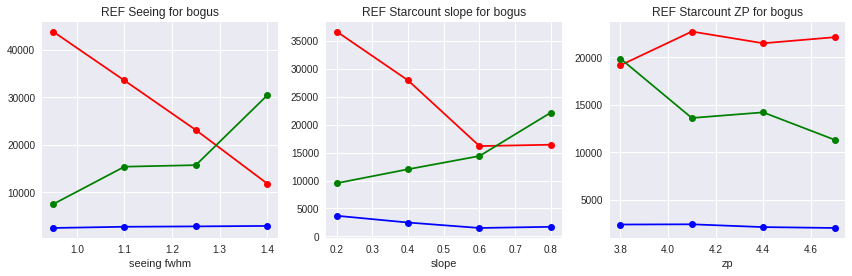

In [120]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
# plt.hist([und_z['refseeing_fwhm'], und_h['refseeing_fwhm'], und_b['refseeing_fwhm']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=True)
cumulative=False
x_bins, vals = custom_histogram(bogus_b['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h['refseeing_fwhm'], cumulative=cumulative, bins=bins_fwhm)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('seeing fwhm')
#plt.ylim(2500, 5000)
plt.title('REF Seeing for bogus')

plt.subplot(1, 3, 2)
# plt.hist([und_z['refstarcount_slope'], und_h['refstarcount_slope'], und_b['refstarcount_slope']],
#          color=['blue', 'green', 'red'], 
#          label=['Zackay', 'Hotpants', 'Bramich'],
#          cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(bogus_b['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(bogus_z['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(bogus_h['refstarcount_slope'], cumulative=cumulative, bins=bins_slope)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
plt.xlabel('slope')
# plt.xlim(0, 1.)
#plt.ylim(2500, 5000)
plt.title('REF Starcount slope for bogus')

plt.subplot(1, 3, 3)
# plt.hist([np.log10(und_z['refstarcount_zp']), 
#           np.log10(und_h['refstarcount_zp']), 
#           np.log10(und_b['refstarcount_zp'])],
#           color=['blue', 'green', 'red'], 
#           label=['Zackay', 'Hotpants', 'Bramich'],
#           cumulative=False, alpha=0.6, normed=False)
cumulative=False
x_bins, vals = custom_histogram(np.log10(bogus_b['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'ro-', label='Bramich')
x_bins, vals = custom_histogram(np.log10(bogus_z['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'bo-', label='Zackay')
x_bins, vals = custom_histogram(np.log10(bogus_h['refstarcount_zp']), cumulative=cumulative, bins=bins_zp)
plt.plot(x_bins, vals, 'go-', label='Hotpants')
#plt.ylim(2500, 5000)
# plt.xlim(3, 6)
plt.xlabel('zp')
plt.title('REF Starcount ZP for bogus')

plt.tight_layout()
plt.show()

## Checking on the outliers

In [121]:
from astropy.nddata.utils import extract_array
from astropy.io import fits


def get_patch_bramich(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff_ois.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    
    
def get_patch_zackay(x, y, image_id):
    """Gets data from a row of a table, from a bramich subtracted source, and uses
    its coordinates to extract a patch from the image.
    """
    size = (14, 14)
    
    path = os.path.join('/home/bruno/Data/RBpipeline/images', 
                        'img'+str(image_id).zfill(5))
    filepath = os.path.join(path, 'diff.fits')
    
    pixdata = fits.getdata(filepath)
    
    patch = extract_array(pixdata, size, (x, y))
    
    return patch
    

In [122]:
outliers_b = bogus_b[bogus_b.CLASS_STAR > .97]

In [123]:
outliers_b

,id_b,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,mag,mu,sn,id,path,crossmatched,refstarcount_zp,refstarcount_slope,refseeing_fwhm,exec_time
2485,3541,84,869.4032,171.4026,17.6519,0.2141,1893.867,340.0518,16.8066,0.195,...,22.666308,69.42399,5.569349,28,/home/bruno/Data/NewRBpipeline/images/img00028...,1,8000.0,0.5,0.8,8.952524


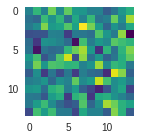

In [124]:
plt.figure(figsize=( 6, 2*len(outliers_b)))
stack = np.zeros((14, 14))
for i in range(len(outliers_b)):
    patch = get_patch_bramich(outliers_b[i:i+1]['Y_IMAGE'], 
                              outliers_b[i:i+1]['X_IMAGE'], 
                              int(outliers_b[i:i+1]['image_id']))
    plt.subplot(len(outliers_b), 1 , i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')
    stack += patch

In [125]:
outliers_z = bogus_z[bogus_z.ELONGATION > 8]

In [126]:
outliers_z

,id_b,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,mag,mu,sn,id,path,crossmatched,refstarcount_zp,refstarcount_slope,refseeing_fwhm,exec_time
5,17,17,82.58381,5.050273,20.2078,0.0664,16.196740,4.398268,21.9764,0.2949,...,22.92929,18.947525,3.682527,1,/home/bruno/Data/NewRBpipeline/images/img00001...,1,4000.0,0.1,1.0,9.247798
119,411,13,407.97730,5.864089,18.4734,0.0156,16.793260,4.401696,21.9372,0.2847,...,22.89009,11.710703,3.815179,9,/home/bruno/Data/NewRBpipeline/images/img00009...,1,4000.0,0.5,1.0,4.215006
133,458,1,311.98710,6.109494,18.7647,0.0213,6.068614,4.378782,23.0423,0.7836,...,23.99519,10.322004,1.385914,10,/home/bruno/Data/NewRBpipeline/images/img00010...,1,4000.0,0.5,1.2,3.991786
146,552,5,583.87440,14.437380,18.0842,0.0269,48.360290,3.896225,20.7888,0.0875,...,21.74169,0.968148,12.412089,12,/home/bruno/Data/NewRBpipeline/images/img00012...,1,4000.0,0.7,0.8,4.222382
158,612,3,653.07340,7.534125,17.9626,0.0125,1.408141,4.393113,24.6284,3.3881,...,25.58129,7.313830,0.320534,13,/home/bruno/Data/NewRBpipeline/images/img00013...,1,4000.0,0.7,1.0,4.410019
159,613,4,1217.23200,14.572990,17.2866,0.0130,141.023500,4.045172,19.6268,0.0312,...,20.57969,1.690866,34.862176,13,/home/bruno/Data/NewRBpipeline/images/img00013...,1,4000.0,0.7,1.0,4.410019
165,656,47,221.61710,4.078902,19.1360,0.0200,7.198334,4.393113,22.8569,0.6628,...,23.80979,31.289149,1.638550,13,/home/bruno/Data/NewRBpipeline/images/img00013...,1,4000.0,0.7,1.0,4.410019
168,690,34,53.25950,3.571446,20.6840,0.0728,15.726340,4.389784,22.0084,0.3031,...,22.96129,18.225619,3.582486,14,/home/bruno/Data/NewRBpipeline/images/img00014...,1,4000.0,0.7,1.2,4.117837
174,698,3,99.01295,4.531519,20.0108,0.0497,13.490850,4.386789,22.1749,0.3531,...,23.12779,23.932051,3.075336,15,/home/bruno/Data/NewRBpipeline/images/img00015...,1,4000.0,0.7,1.4,4.012856
213,867,2,101.52470,4.757114,19.9836,0.0509,3.274284,4.404870,23.7122,1.4610,...,24.66509,21.739938,0.743333,19,/home/bruno/Data/NewRBpipeline/images/img00019...,1,4000.0,0.9,1.4,4.039127


In [127]:
plt.figure(figsize=(6*len(outliers_z), 12))
for i in range(len(outliers_z)):
    patch = get_patch_zackay(outliers_z[i:i+1]['Y_IMAGE'], 
                              outliers_z[i:i+1]['X_IMAGE'], 
                              int(outliers_z[i:i+1]['image_id']))
    plt.subplot(1, len(outliers_z), i+1)
    plt.grid()
    plt.imshow(patch, cmap='viridis', interpolation='none')

ValueError: Image size of 92016x864 pixels is too large. It must be less than 2^16 in each direction.

In [128]:
import gc
gc.collect()

180